In [30]:
import os
import warnings

import pandas as pd
from tqdm import tqdm

In [31]:
# 预设值
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None  # 展示所有列

In [32]:
folders = ['requests_minute', 'memory_usage_minute', 'cpu_usage_minute', 'instances_minute', 'memory_limit_minute',
           'cpu_limit_minute']
base_path = '../datasets/huawei/private_dataset'  # 更新为你的数据集的基本路径

In [33]:
# 初始化空DataFrame来存储最终结果
final_df = pd.DataFrame()

day_count = 1
# 遍历每一天
for day in tqdm(range(235)):  # 从day_000.csv到day_234.csv
    if day_count > 52:
        break
    day_str = f'day_{day:03}.csv'
    day_data = None

    # 遍历每个文件夹（数据类型）
    for folder in folders:
        file_path = os.path.join(base_path, folder, day_str)

        try:
            # 读取数据
            temp_df = pd.read_csv(file_path)
        except FileNotFoundError:
            # print(f'文件{file_path}不存在')
            continue

        # 将数据从宽格式转换为长格式
        temp_df_long = temp_df.melt(id_vars=['day', 'time'], var_name='API_ID', value_name=folder)

        # 转换API_ID为整型，以便于后续处理
        temp_df_long['API_ID'] = temp_df_long['API_ID'].astype(int)

        # 合并数据
        if day_data is None:
            day_data = temp_df_long
        else:
            day_data = pd.merge(day_data, temp_df_long, on=['day', 'time', 'API_ID'])

    # 将当天的数据添加到最终结果DataFrame中
    final_df = pd.concat([final_df, day_data], ignore_index=True)
    if day_data is not None:
        day_count += 1

# 填充缺失值为0
final_df.fillna(0, inplace=True)

# 重命名列以符合要求
final_df.rename(columns={'requests_minute': 'requests_minute',
                         'memory_usage_minute': 'memory_usage_minute',
                         'cpu_usage_minute': 'cpu_usage_minute',
                         'instances_minute': 'instances_minute',
                         'cpu_limit_minute': 'cpu_limit_minute',
                         'memory_limit_minute': 'memory_limit_minute',
                         }, inplace=True)

final_df = final_df.sort_values(by=['API_ID', 'time']).reset_index(drop=True)
seconds_per_day = 24 * 3600
final_df['seconds_since_midnight'] = final_df['time'] - (final_df['day'] * seconds_per_day)
# 计算相对于当天的小时
final_df['hour'] = final_df['seconds_since_midnight'] // 3600
# 计算一小时内的分钟
final_df['minute'] = (final_df['seconds_since_midnight'] % 3600) // 60

final_df['total_cpu_usage'] = (final_df['cpu_usage_minute'] * final_df['instances_minute']).round(3)
final_df['total_memory_usage'] = (final_df['memory_usage_minute'] * final_df['instances_minute']).round(3)
final_df['absolute_cpu_usage'] = (final_df['cpu_usage_minute'] * final_df['cpu_limit_minute']).round(3)
final_df['absolute_memory_usage'] = (final_df['memory_usage_minute'] * final_df['memory_limit_minute']).round(3)

final_df = final_df.drop(['seconds_since_midnight'], axis=1)

order = ['day', 'time', 'hour', 'minute', 'API_ID', 'requests_minute',
         'memory_usage_minute', 'cpu_usage_minute', 'instances_minute', 'memory_limit_minute',
         'cpu_limit_minute', 'total_cpu_usage', 'total_memory_usage', 'absolute_cpu_usage', 'absolute_memory_usage',
         ]
final_df = final_df[order]

print(final_df.head())
# 将合并后的数据保存到CSV文件
final_csv_path = os.path.join('../datasets/huawei', 'combined_dataset.csv')
final_df.to_csv(final_csv_path, index=False)

 26%|██▌       | 61/235 [00:33<01:34,  1.85it/s]


   day  time  hour  minute  API_ID  requests_minute  memory_usage_minute  \
0    0     0     0       0       0              0.0                  0.0   
1    0    60     0       1       0              0.0                  0.0   
2    0   120     0       2       0              0.0                  0.0   
3    0   180     0       3       0              0.0                  0.0   
4    0   240     0       4       0              0.0                  0.0   

   cpu_usage_minute  instances_minute  memory_limit_minute  cpu_limit_minute  \
0               0.0               0.0                  0.0               0.0   
1               0.0               0.0                  0.0               0.0   
2               0.0               0.0                  0.0               0.0   
3               0.0               0.0                  0.0               0.0   
4               0.0               0.0                  0.0               0.0   

   total_cpu_usage  total_memory_usage  absolute_cpu_usage  \


In [39]:
API_IDS = [160, 150, 65, 72, 147, 164, 28, 165, 131, 39]
# 从final_df中筛选出API_ID在API_IDS列表中的数据
filtered_df = final_df[final_df['API_ID'].isin(API_IDS)]

filtered_df = filtered_df.sort_values(by=['API_ID', 'time']).reset_index(drop=True)
final_csv_path = os.path.join('../datasets/huawei', 'data.csv')
filtered_df.to_csv(final_csv_path, index=False)

In [40]:
# 按照10min聚合
data_path = '../datasets/huawei/data.csv'
data_df = pd.read_csv(data_path)
# print(data_df.describe())

data_df['time_period'] = data_df['time'] // 600
# Group by the new time period, aggregating data accordingly
aggregated_data = data_df.groupby(['API_ID', 'time_period']).agg(
    day=('day', 'last'),  # Assuming day does not change within 10 minutes, taking mean is fine
    hour=('hour', 'last'),
    minute=('minute', 'last'),
    time=('time', 'last'),
    requests_minute=('requests_minute', 'mean'),
    memory_usage_minute=('memory_usage_minute', 'mean'),
    cpu_usage_minute=('cpu_usage_minute', 'mean'),
    instances_minute=('instances_minute', 'mean'),
    memory_limit_minute=('memory_limit_minute', 'mean'),
    cpu_limit_minute=('cpu_limit_minute', 'mean'),
    total_cpu_usage=('total_cpu_usage', 'mean'),
    min_total_cpu_usage=('total_cpu_usage', 'min'),
    max_total_cpu_usage=('total_cpu_usage', 'max'),
    total_memory_usage=('total_memory_usage', 'mean'),
    min_total_memory_usage=('total_memory_usage', 'min'),
    max_total_memory_usage=('total_memory_usage', 'max'),
    absolute_cpu_usage=('absolute_cpu_usage', 'mean'),
    absolute_memory_usage=('absolute_memory_usage', 'mean'),
).reset_index()

# Display the first few rows of the aggregated dataframe
# print(aggregated_data.head())
print(aggregated_data.describe())
aggregated_data = aggregated_data.sort_values(by=['API_ID', 'time_period']).reset_index(drop=True)
final_csv_path = os.path.join('../datasets/huawei', 'data.csv')
aggregated_data.to_csv(final_csv_path, index=False)

             API_ID   time_period           day          hour        minute  \
count  74880.000000  74880.000000  74880.000000  74880.000000  74880.000000   
mean     112.100000   4565.961538     31.211538     11.500000     34.000000   
std       52.001213   2704.132303     18.776478      6.922233     17.078365   
min       28.000000      0.000000      0.000000      0.000000      9.000000   
25%       65.000000   1871.750000     12.750000      5.750000     19.000000   
50%      139.000000   5039.500000     34.500000     11.500000     34.000000   
75%      160.000000   6911.250000     47.250000     17.250000     49.000000   
max      165.000000   8783.000000     60.000000     23.000000     59.000000   

               time  requests_minute  memory_usage_minute  cpu_usage_minute  \
count  7.488000e+04     7.488000e+04         74880.000000      74880.000000   
mean   2.740117e+06     1.579172e+05             0.213768          0.152973   
std    1.622479e+06     2.334527e+05             0.

7488


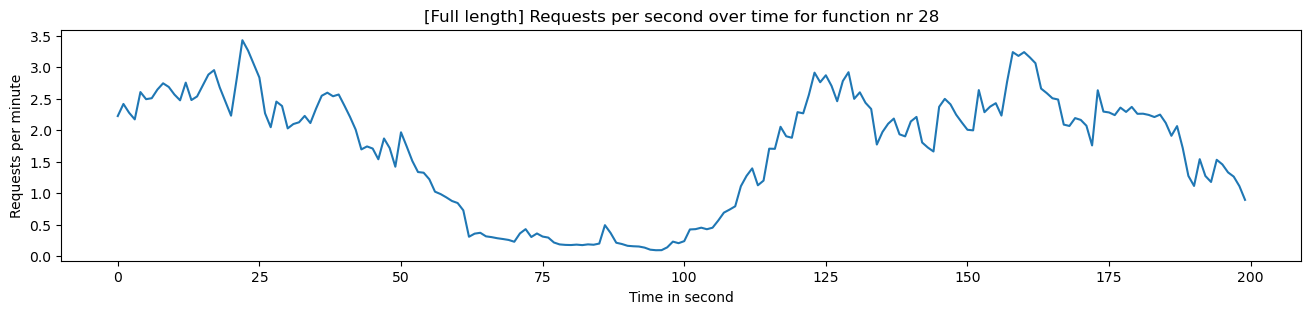

7488


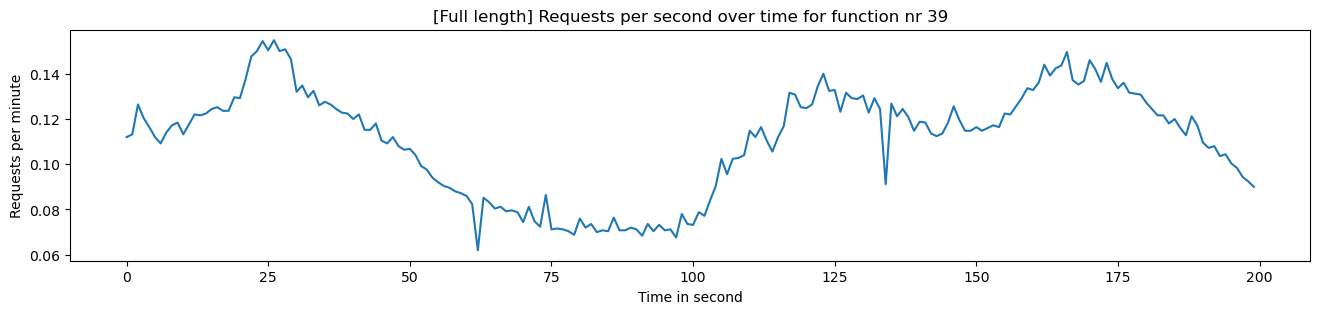

7488


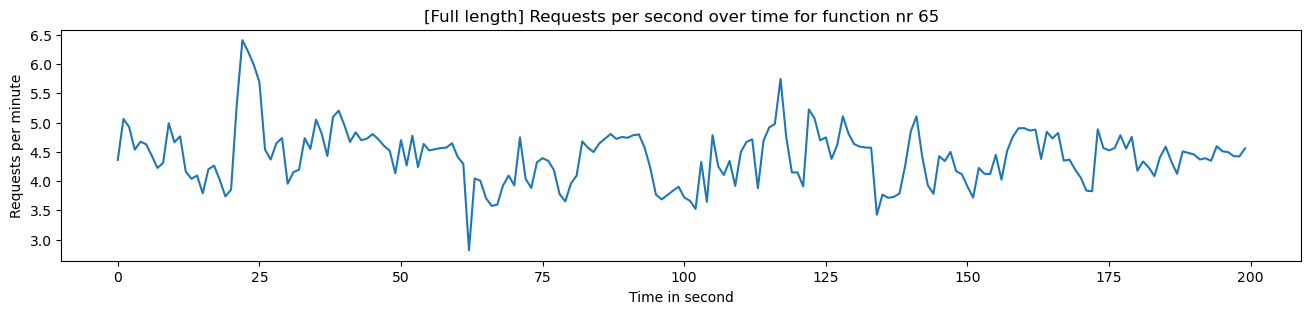

7488


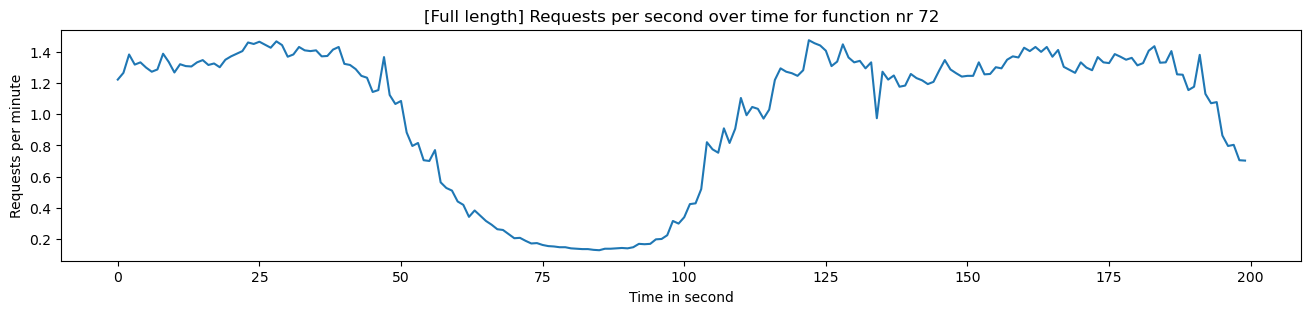

7488


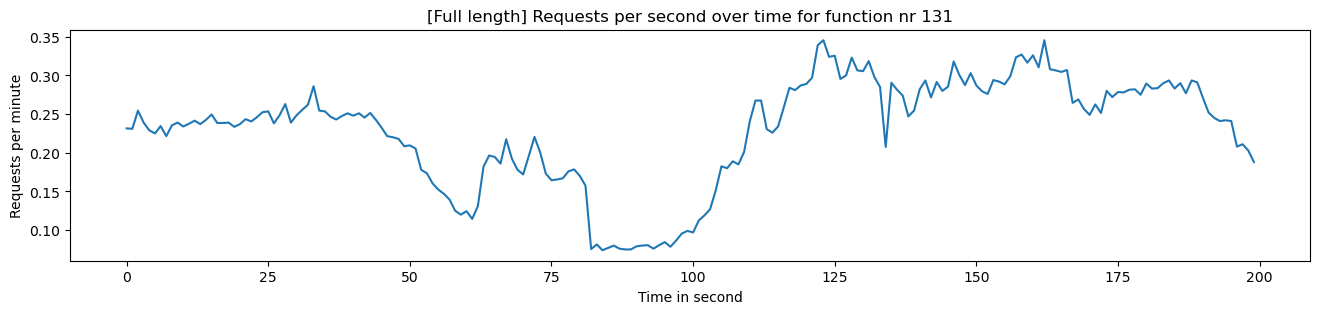

7488


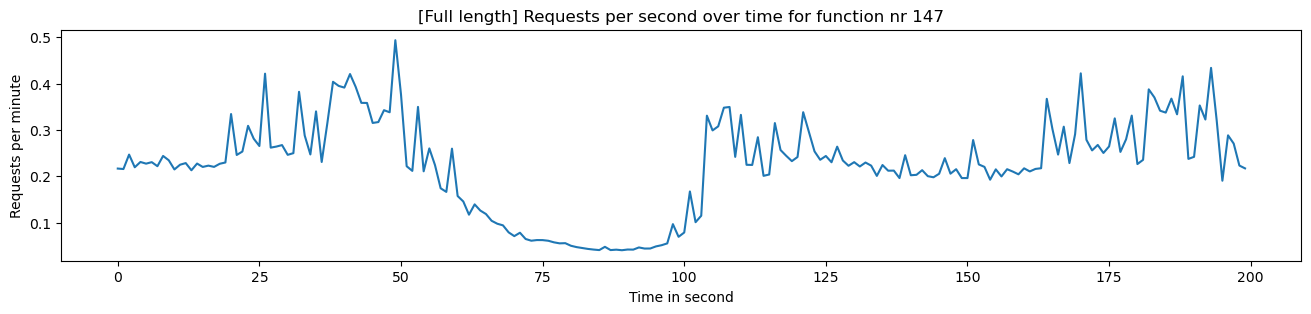

7488


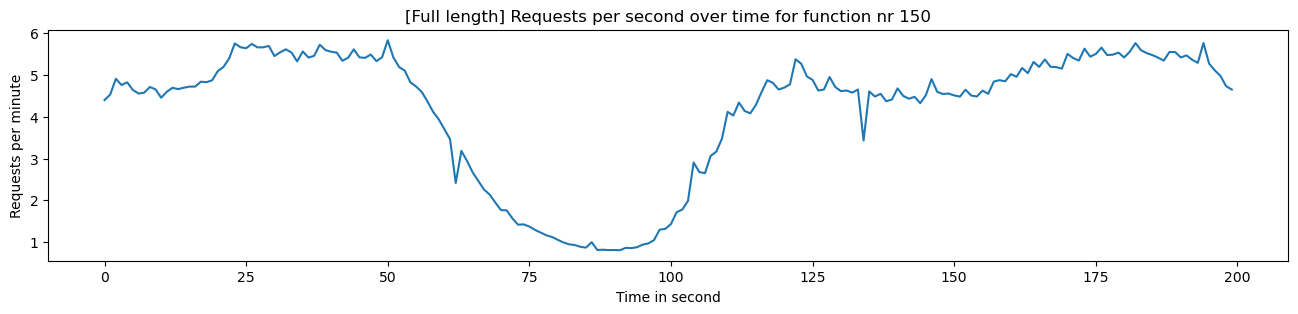

7488


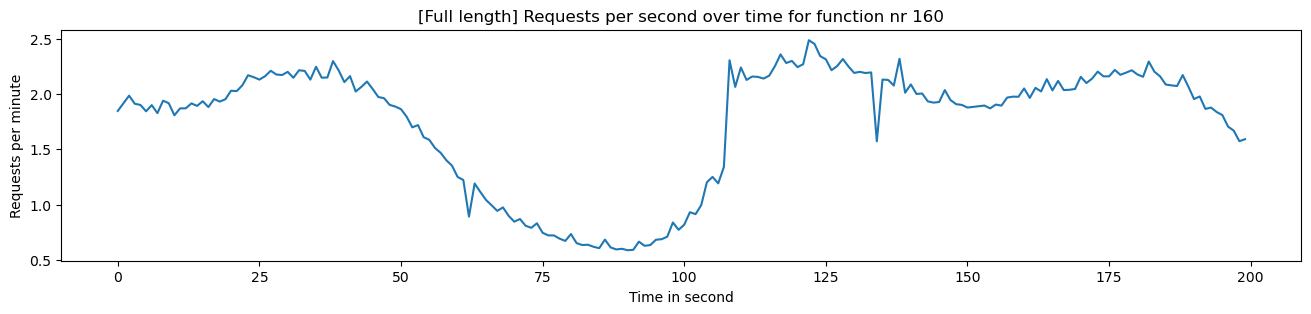

7488


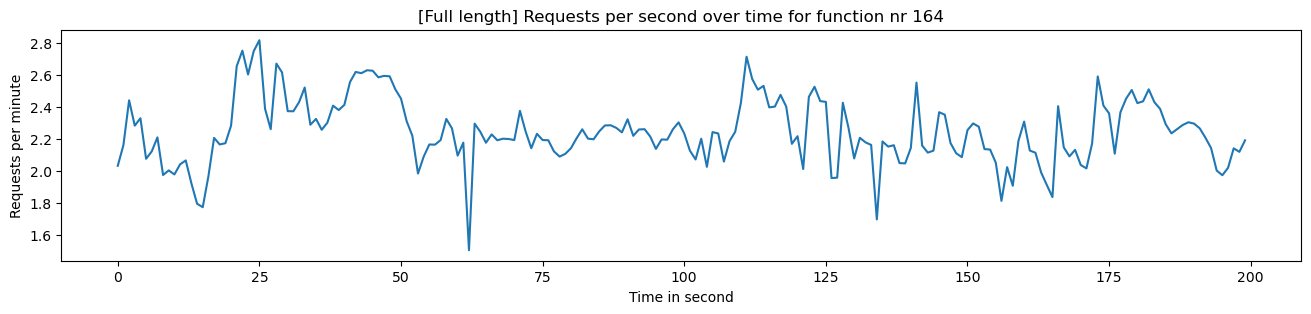

7488


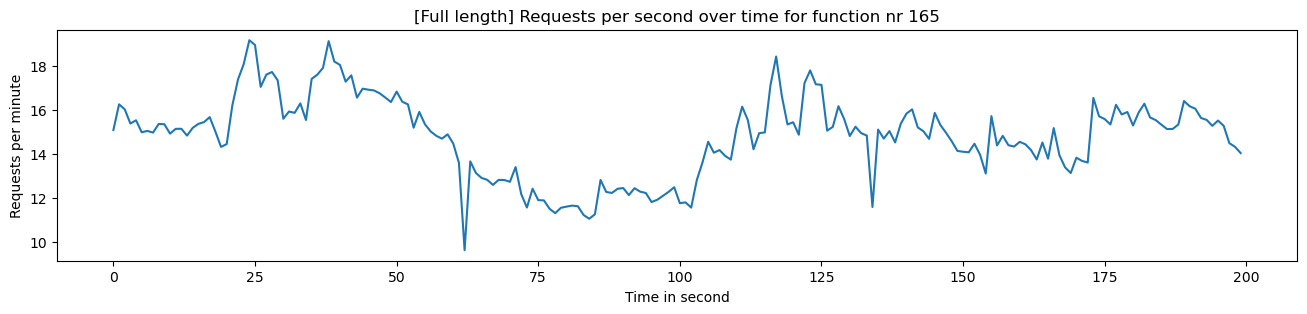

In [41]:
from matplotlib import pyplot as plt

API_IDS = aggregated_data['API_ID'].unique()
for API_ID in API_IDS:
    fig = plt.figure(figsize=(16, 3))
    cpu_usage = aggregated_data[aggregated_data['API_ID'] == API_ID]['total_cpu_usage'].values
    # time_range = aggregated_data[aggregated_data['API_ID'] == API_ID]['time'].values

    print(len(cpu_usage))
    start = 7288
    end = 7488

    plt.plot(cpu_usage[start:end])
    # plt.scatter(time_range, cpu_usage, s=1)
    # plt.plot(cpu_usage)
    plt.xlabel('Time in second')
    plt.ylabel('Requests per minute')
    plt.title('[Full length] Requests per second over time for function nr {}'.format(API_ID))
    plt.show()